🎯 **TALLER 1: SERIES DE TIEMPO**

📅 **Fecha:** 2025

👤 **Equipo:** [Hector Hernan Betancourt Lopez - Marcela Fajardo Bermúdez]

#### * Empleando la información del número de ocupados en miles de personas (Ocupados) para las 13 principales ciudades, encuentre el mejor pronóstico para los próximos 6 meses. Escriba un breve informe de máximo una página de texto que explique cómo llega a sus proyeccciones y presente las proyecciones. Aclare en el texto cuáles serían las limitaciones de sus pronósticos.

## **1. Carga de paquetes**

In [1]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error


## **2. Carga de datos**

Nuestra primera tarea será leer el archivo de Excel. Para eso podemos emplear el paquete Pandas. Carguemos los datos en un objeto que denominaremos data.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data = pd.read_excel("/content/drive/MyDrive/Maestría_ciencia_de_datos/Fundamentos_Analitica/S7/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


(222, 4)


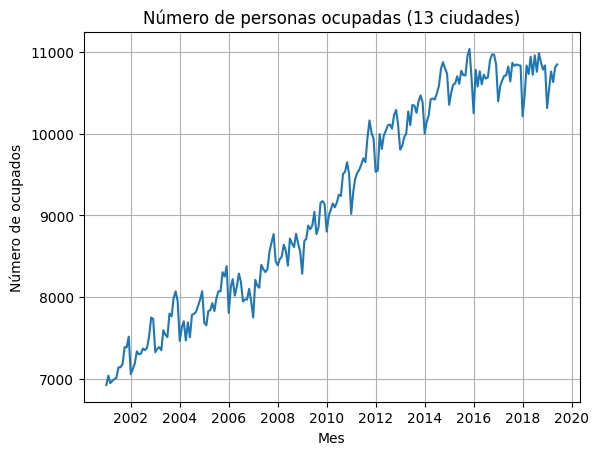

In [4]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
plt.title("Número de personas ocupadas (13 ciudades)")
plt.xlabel("Mes")
plt.ylabel("Número de ocupados")
plt.plot(data[['Ocupados']])
plt.grid()
plt.show()

## **3. Encontrando los componentes de una serie de tiempo**

En algunas ocasiones puede ser útil empezar nuestro análisis descomponiendo la serie de tiempo en sus componentes: **tendencia**, **estacionalidad** y **componente puramente aleatorio**. Una forma de hacer esto es empleando la función seasonal_decompose.

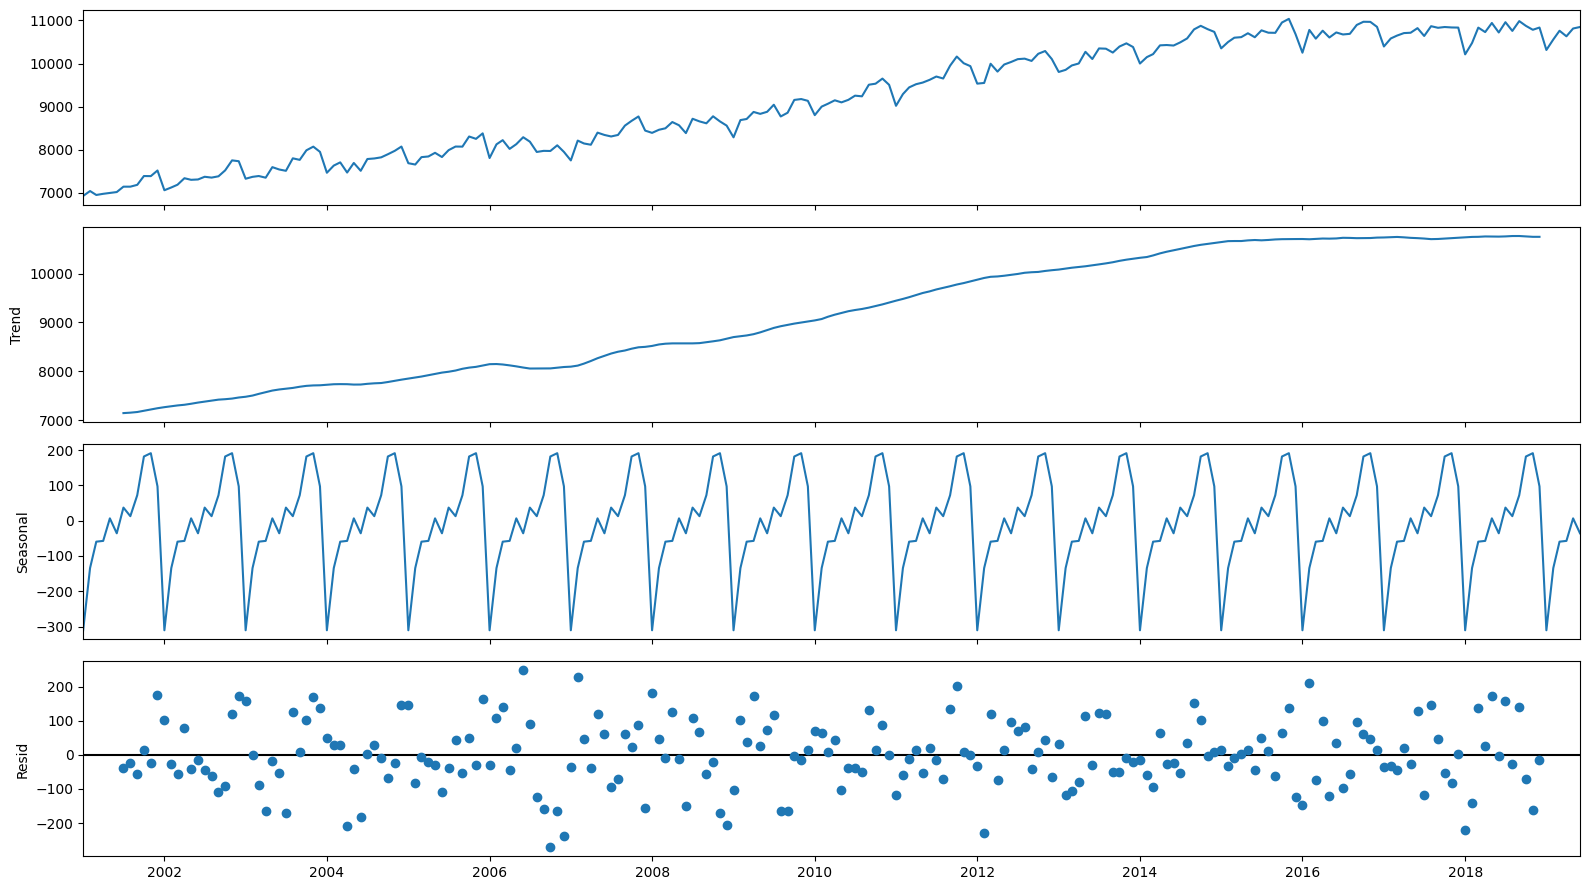

In [5]:
# td_componentes = seasonal_decompose(data[['Ocupados']],model="multiplicative")
td_componentes = seasonal_decompose(data[['Ocupados']],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

Asi se extrae cada elemento de la descomposición de la serie.

In [6]:
td_componentes.seasonal
#td_componentes.trend
#td_componentes.resid

,seasonal
mes,
2001-01-01,-310.570069
2001-02-01,-134.331549
2001-03-01,-59.585841
2001-04-01,-57.385905
2001-05-01,6.435912
...,...
2019-02-01,-134.331549
2019-03-01,-59.585841
2019-04-01,-57.385905


Podemos observar el componente estacional marcado en la serie, una tendencia lineal de los datos.

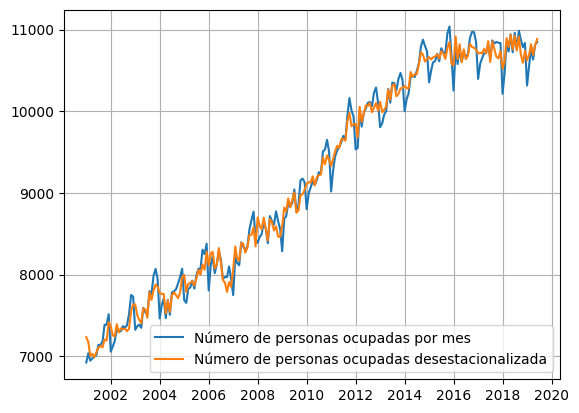

In [7]:
td_desestacionalizada = data['Ocupados']-td_componentes.seasonal

plt.plot(data[['Ocupados']],label="Número de personas ocupadas por mes")
plt.plot(td_desestacionalizada,label="Número de personas ocupadas desestacionalizada")
plt.legend()
plt.grid()
plt.show()


### **4. Pronosticando metodos de suavización**

Antes de continuar es importante guardar una parte de la muestra para evaluar el comportamiento de los modelos por fuera de muestra (out-of-sample). Guardemos un año de datos.

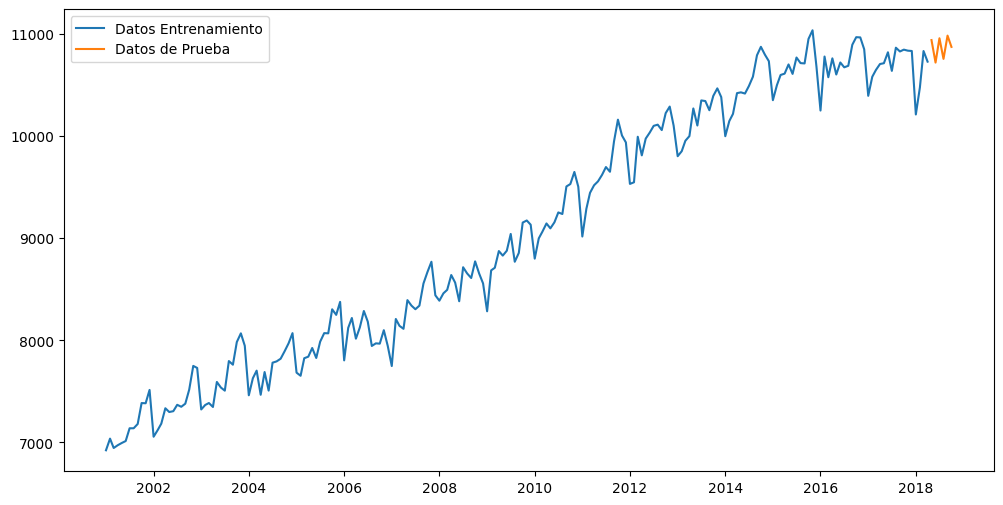

In [8]:
train_len = 208
h = 6
train_td = data[['Ocupados']][:train_len]
# test_td = data[['Ocupados']][train_len:]
test_td = data[['Ocupados']][train_len:train_len+h]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(test_td,label="Datos de Prueba")
plt.legend()
plt.show()

In [9]:
train_td

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462
...,...
2017-12-01,10834.330
2018-01-01,10212.612
2018-02-01,10476.311


In [10]:
test_td

,Ocupados
mes,
2018-05-01,10941.294
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338


## **4.1 Promedio movil**

In [11]:
## Considerando el dato actual
ma_2= train_td.rolling(2,min_periods=2).mean()
ma_3= train_td.rolling(3,min_periods=2).mean()
ma_4= train_td.rolling(4,min_periods=2).mean()
ma_5= train_td.rolling(5,min_periods=2).mean()

In [12]:
## Sin considerar el dato actual
ma_2= train_td.shift().rolling(2,min_periods=2).mean()
ma_3= train_td.shift().rolling(3,min_periods=2).mean()
ma_4= train_td.shift().rolling(4,min_periods=2).mean()
ma_5= train_td.shift().rolling(5,min_periods=2).mean()


In [13]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:]

In [14]:
ma_2_f= fore_ma(train_td,2,6)
ma_3_f= fore_ma(train_td,3,6)
ma_4_f= fore_ma(train_td,4,6)
ma_5_f= fore_ma(train_td,5,6)

In [15]:
test_td

,Ocupados
mes,
2018-05-01,10941.294
2018-06-01,10720.946
2018-07-01,10959.197
2018-08-01,10756.782
2018-09-01,10984.928
2018-10-01,10874.338


In [16]:
ma_2_f

,Ocupados
mes,
2018-05-01,10781.978500
2018-06-01,10755.977750
2018-07-01,10768.978125
2018-08-01,10762.477937
2018-09-01,10765.728031
2018-10-01,10764.102984


In [17]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_td,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_td,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_td,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_td,ma_5_f ))

In [18]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

143.19258659140885 190.5389618896666 254.9786194278905 258.3762808593907


* **Nota:**

El menor error corresponde al modelo de promedio móvil con ventana de 2 meses(rmse_ma_2), ya que significa que el pronóstico tiene, en promedio, menos error respecto a los datos reales del periodo de prueba

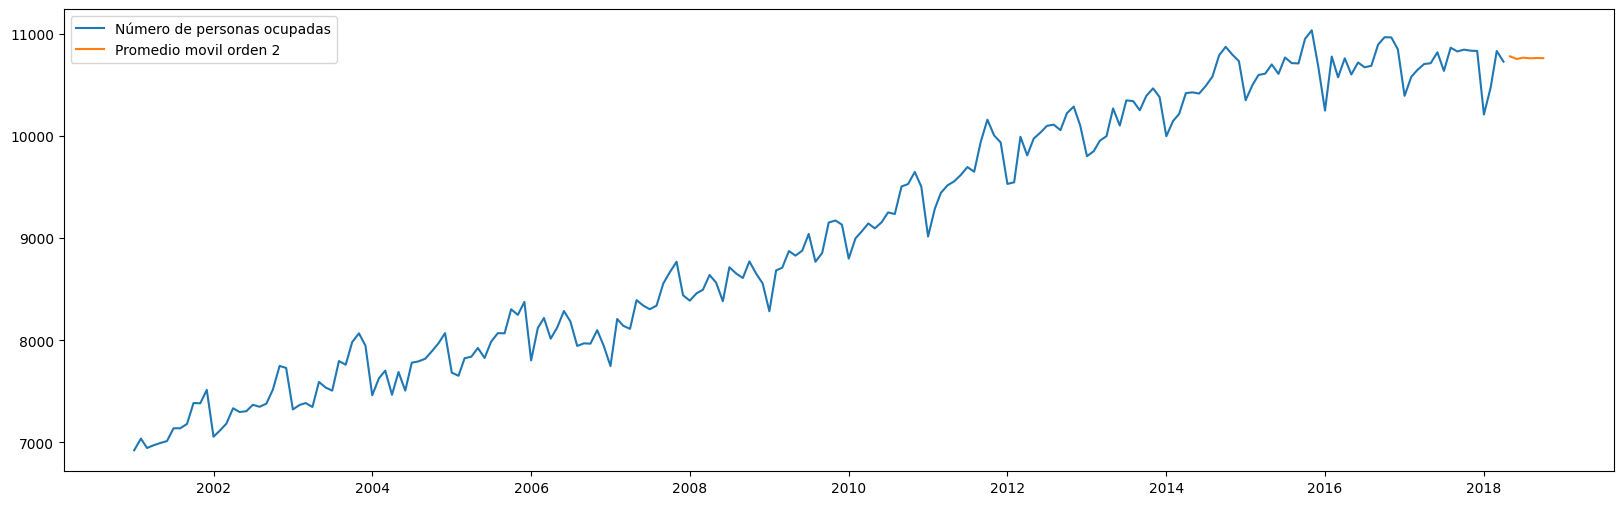

In [19]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_td,label="Número de personas ocupadas")
plt.plot(ma_2_f,label="Promedio movil orden 2")
plt.legend()
plt.show()

## **4.2 Suavizacion Exponencial Simple**

In [20]:
# Build model.
ets_model = ETSModel(endog=train_td['Ocupados'],error="add")#,trend="add",seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast      lower_95      upper_95
2018-05-01     10720.36905  10363.683336  11077.054763
2018-06-01     10720.36905  10295.289751  11145.448348
2018-07-01     10720.36905  10236.468108  11204.269991
2018-08-01     10720.36905  10184.059593  11256.678506
2018-09-01     10720.36905  10136.335194  11304.402905
2018-10-01     10720.36905  10092.226346  11348.511753


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


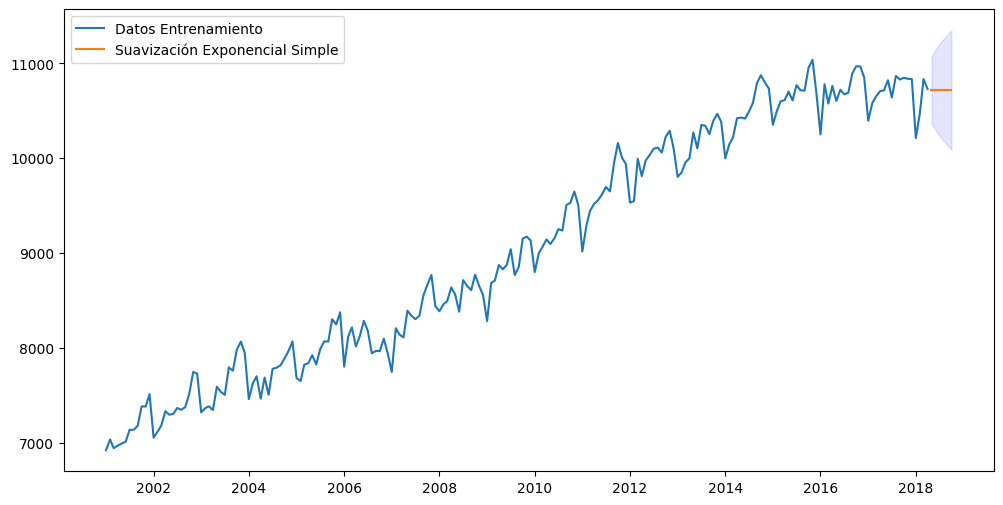

In [21]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [22]:
ets_result.alpha

np.float64(0.6482762085573379)

In [23]:
rmse = np.sqrt(mean_squared_error(test_td,point_forecast ))
print(rmse)

182.97118869311097


En esta caso el α estimado es 0.6482276 Y el RMSE en la muestra de evaluación es 1.82

## **4.3 Suavizacion Exponencial Lineal (Holt)**

In [24]:
# Build model.
ets_model = ETSModel(endog=train_td['Ocupados'],error="mul",trend="mul")#,seasonal="mul" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast      lower_95      upper_95
2018-05-01    10749.538826  10349.592783  11165.793736
2018-06-01    10773.218919  10266.345848  11211.963783
2018-07-01    10796.951177  10270.795293  11301.522284
2018-08-01    10820.735715  10235.676417  11379.015732
2018-09-01    10844.572647  10222.354384  11503.728007
2018-10-01    10868.462089  10202.260225  11531.773865


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


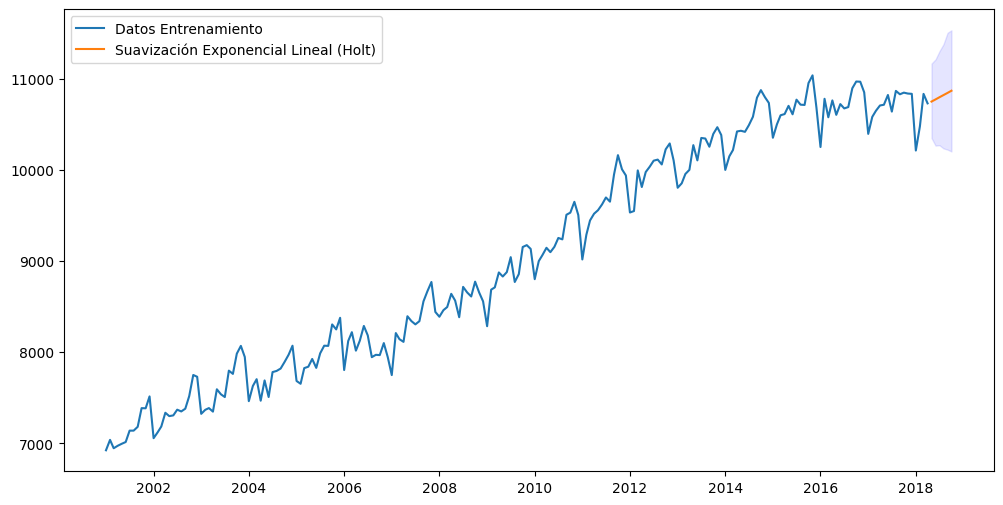

In [25]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

En esta caso el α estimado es 0.5619342865299669 y el β estimado es 5.619342865299669$^{-5}$. Y el RMSE en la muestra de evaluación es 1.2780044501304348.

In [26]:
print(ets_result.alpha,ets_result.beta)

0.5619342865299669 5.619342865299669e-05


In [27]:
rmse_holt = np.sqrt(mean_squared_error(test_td,preds_holt['Point_forecast']))
print(rmse_holt)

122.23641086408429


## **4.3 Suavizacion Exponencial Lineal de Winters (Holt-Winters)**

In [28]:
# Build model
ets_model = ETSModel(endog=train_td['Ocupados'],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


            Point_forecast      lower_95      upper_95
2018-05-01    10778.678865  10522.766255  11034.591475
2018-06-01    10842.424848  10571.472051  11113.377646
2018-07-01    10833.154352  10547.950639  11118.358064
2018-08-01    10942.090639  10643.312324  11240.868955
2018-09-01    10997.492183  10685.727222  11309.257145
2018-10-01    11095.853348  10771.619042  11420.087655


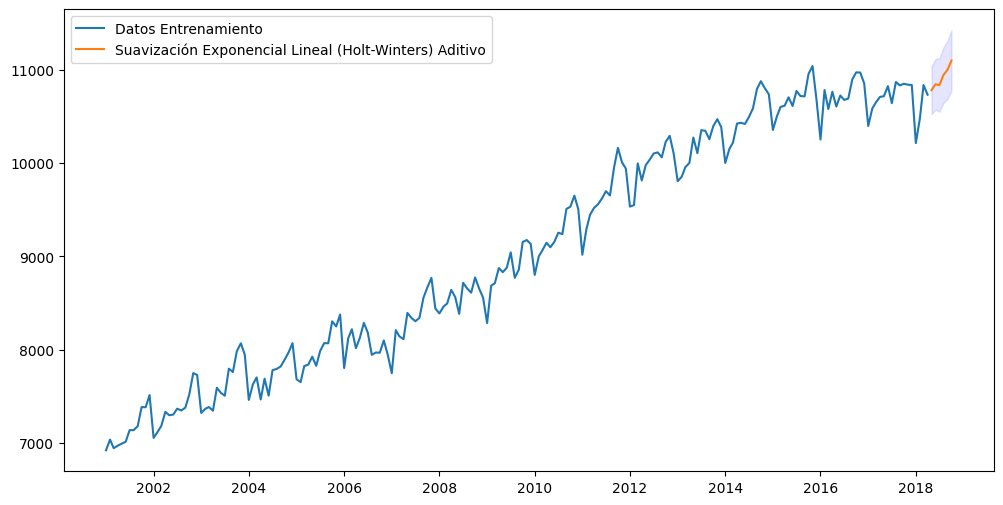

In [29]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [30]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.34780943064780695 3.4780943064780696e-05 0.32230764286217156


In [31]:
rmse_hw_add = np.sqrt(mean_squared_error(test_td,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

153.108753279205


In [32]:
# Build model.
ets_model = ETSModel(endog=train_td['Ocupados'],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(6)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast      lower_95      upper_95
2018-05-01    10787.445417  10558.887373  11018.694465
2018-06-01    10757.065803  10483.902381  11008.955507
2018-07-01    10832.086555  10525.112545  11112.654029
2018-08-01    10816.529577  10501.722515  11120.620948
2018-09-01    10878.550568  10524.956759  11215.243854
2018-10-01    11021.780970  10628.830838  11388.938515


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


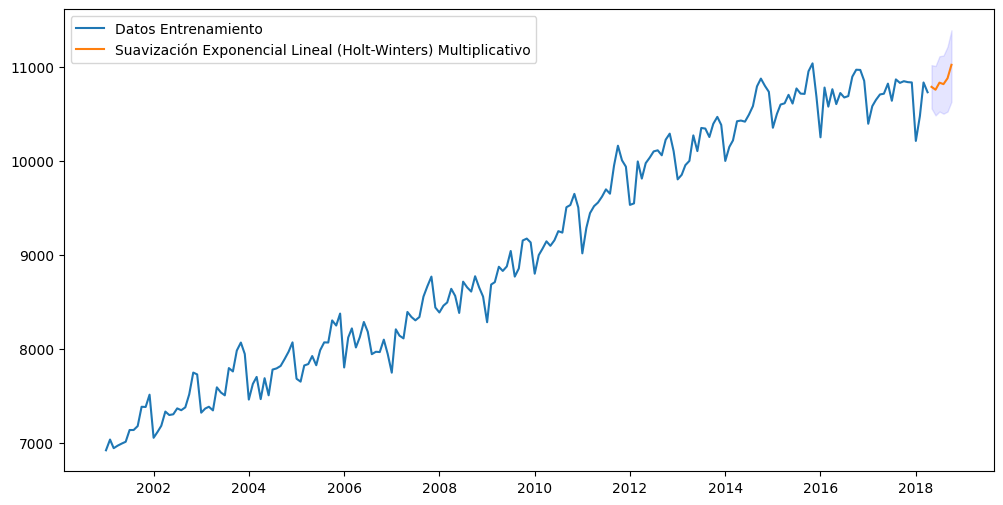

In [33]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_td,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

In [34]:
print(ets_result.alpha,ets_result.gamma)

0.6067555493983304 3.932444506016696e-05


In [35]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_td,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

113.83939871305225


## **5. Suavización Exponencial All Data**

### Se ajusta el modelo con el train y se observan los hiperparametros obtenidos en la optimización

In [36]:
data.columns

Index(['TD_13ciudades', 'Ocupados', 'Desocupados', 'Inactivos'], dtype='object')

In [37]:
ets_model = ETSModel(endog=train_td['Ocupados'],error="add",trend="add",seasonal="add")
ets_result = ets_model.fit()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [38]:
## Se obtienen los hiperparametros

print(ets_result.alpha)
print(ets_result.beta)
print(ets_result.gamma)
print(ets_result.param_names)

0.34780943064780695
3.4780943064780696e-05
0.32230764286217156
['smoothing_level', 'smoothing_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend', 'initial_seasonal.0', 'initial_seasonal.1', 'initial_seasonal.2', 'initial_seasonal.3', 'initial_seasonal.4', 'initial_seasonal.5', 'initial_seasonal.6', 'initial_seasonal.7', 'initial_seasonal.8', 'initial_seasonal.9', 'initial_seasonal.10', 'initial_seasonal.11']


In [39]:
## Ahora se ajusta el modelo final con todos los datos

final_model = ETSModel(endog=data['Ocupados'],error="add",trend="add",seasonal="add")
final_model_fit = final_model.fit_constrained({'smoothing_level': 0.34780943064780695,'smoothing_trend': 3.4780943064780696e-05,'smoothing_seasonal':0.32230764286217156})

print(final_model_fit.alpha)
print(final_model_fit.beta)
print(final_model_fit.gamma)

0.34780943064780695
3.4780943064780696e-05
0.32230764286217156


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


El método fit_constrained fuerza el modelo a usar exactamente esos valores para sus parámetros de actualización interna en los filtros de suavización exponencial, manteniendo fija la “velocidad” con la que se ajustan nivel, tendencia y estacionalidad en cada nuevo periodo calculado

In [40]:
point_forecast=final_model_fit.forecast(6)

ci = final_model_fit.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)#.iloc[:,0]
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast      lower_95      upper_95
2019-07-01    10877.361880  10632.996825  11121.726934
2019-08-01    10869.660694  10610.934111  11128.387277
2019-09-01    11004.604884  10732.270430  11276.939337
2019-10-01    11031.523571  10746.227042  11316.820100
2019-11-01    11035.606730  10737.909552  11333.303907
2019-12-01    11008.303888  10698.700019  11317.907756


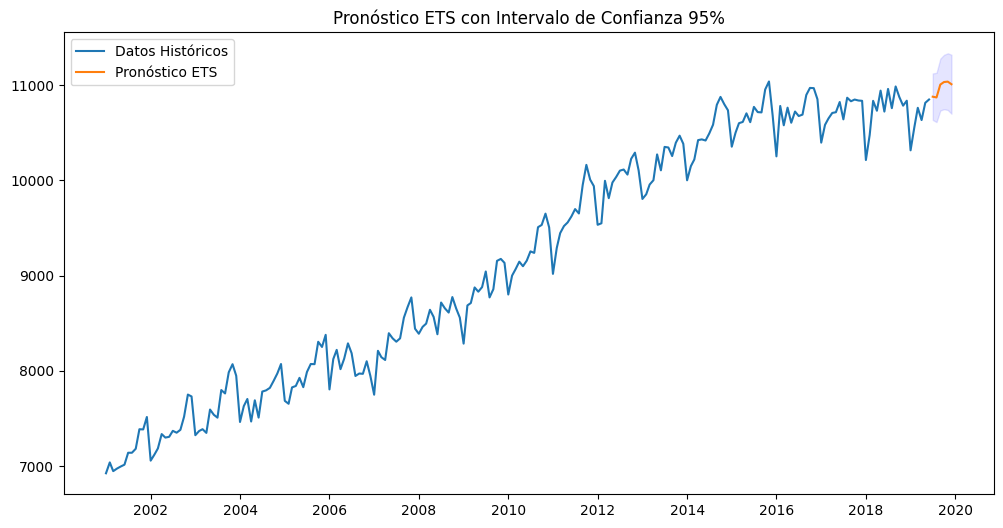

In [41]:
fig = plt.figure(figsize=(12, 6))

# Serie histórica completa de Ocupados
plt.plot(data.index, data['Ocupados'], label="Datos Históricos")

# Pronóstico puntual (6 meses)
plt.plot(preds_hw_add.index, preds_hw_add['Point_forecast'], label="Pronóstico ETS")

# Intervalo de confianza 95%
plt.fill_between(preds_hw_add.index,
                 preds_hw_add['lower_95'],
                 preds_hw_add['upper_95'],
                 color='blue', alpha=0.1)

plt.legend()
plt.title('Pronóstico ETS con Intervalo de Confianza 95%')
plt.show()